In [1]:
#Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
# Install dependencies
!pip install -q torch torchvision
!pip install -q git+https://github.com/facebookresearch/detectron2.git
!pip install -q detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu113/torch1.10/index.html
!pip install -q tensorflow numpy pandas opencv-python-headless seaborn tqdm pydicom

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.7/458.7 kB 18.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 48.6 MB/s eta 0:00:00


In [13]:
!pip install albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/43.1 kB ? eta -:--:--
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.1/43.1 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.3/80.3 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.0/66.0 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 632.7/632.7 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.8/307.8 kB 20.5 MB/s eta 0:00:00


In [14]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.applications import MobileNet, DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.mixed_precision import set_global_policy
import cv2
import matplotlib.pyplot as plt
import os
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import seaborn as sns
import torch
import pickle
import pydicom
import zipfile
from tqdm import tqdm
import logging
from concurrent.futures import ThreadPoolExecutor
from detectron2.config import get_cfg
from detectron2.engine import DefaultTrainer
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.model_zoo import model_zoo
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import Visualizer
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
import copy
import albumentations as A
from tensorflow.keras.utils import Sequence

In [15]:
# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)


In [16]:
# Enable mixed precision
set_global_policy('mixed_float16')

In [17]:
# Define paths
data_path = '/content/drive/MyDrive/Capstone project-Group 12/'
local_image_path = '/content/tmp_images/'
label_csv = f'{data_path}stage_2_train_labels.csv'
zip_path = f'{data_path}stage_2_train_images.zip'
chexnet_weights = f'{data_path}chexnet_weights.h5'
os.makedirs(f'{data_path}plots/', exist_ok=True)
os.makedirs(local_image_path, exist_ok=True)

In [18]:
# Validate paths
for path in [data_path, label_csv, zip_path]:
    if not os.path.exists(path):
        logger.error(f"Path does not exist: {path}")
        raise FileNotFoundError(f"Path does not exist: {path}")

In [19]:
# Load and preprocess data
label_df = pd.read_csv(label_csv)
logger.info(f"Loaded label CSV with {len(label_df)} entries")

In [20]:
label_df.head(3)

patientId   x   y  width  height  Target
0  0004cfab-14fd-4e49-80ba-63a80b6bddd6 NaN NaN    NaN     NaN       0
1  00313ee0-9eaa-42f4-b0ab-c148ed3241cd NaN NaN    NaN     NaN       0
2  00322d4d-1c29-4943-afc9-b6754be640eb NaN NaN    NaN     NaN       0

In [21]:
# Extract images from ZIP
def extract_all_from_zip(zip_path, local_image_path):
    if not os.path.exists(os.path.join(local_image_path, 'stage_2_train_images')):
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(local_image_path)
        logger.info(f"Extracted files to {local_image_path}")
    else:
        logger.info(f"Images already extracted at {local_image_path}")

extract_all_from_zip(zip_path, local_image_path)

In [22]:
# Compute dataset stats
def compute_dataset_stats(label_df, local_image_path, data_path, batch_size=100, max_workers=8):
    cache_file = f'{data_path}dataset_stats.pkl'
    if os.path.exists(cache_file):
        with open(cache_file, 'rb') as f:
            mean, std = pickle.load(f)
        logger.info(f"Loaded cached stats: mean={mean:.4f}, std={std:.4f}")
        return mean, std

    n, mean, m2 = 0, 0.0, 0.0
    def process_image(file_path):
        try:
            image = pydicom.dcmread(file_path).pixel_array.flatten().astype(np.float32) / 255.0
            n_i = len(image)
            mean_i = image.mean()
            m2_i = ((image - mean_i) ** 2).sum()
            return n_i, mean_i * n_i, m2_i
        except Exception:
            return 0, 0.0, 0.0

    for i in tqdm(range(0, len(label_df), batch_size), desc="Computing stats"):
        batch_ids = label_df['patientId'][i:i+batch_size].tolist()
        file_paths = [os.path.join(local_image_path, 'stage_2_train_images', f"{pid}.dcm") for pid in batch_ids]
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            results = list(executor.map(process_image, file_paths))
        for ni, sumi, m2i in results:
            if ni == 0:
                continue
            delta = sumi / ni - mean
            mean += delta * ni / (n + ni)
            m2 += m2i + delta ** 2 * n * ni / (n + ni)
            n += ni

    if n == 0:
        raise ValueError("No valid images found for stats")
    std = np.sqrt(m2 / n)
    with open(cache_file, 'wb') as f:
        pickle.dump((mean, std), f)
    logger.info(f"Cached stats: mean={mean:.4f}, std={std:.4f}")
    return mean, std

mean, std = compute_dataset_stats(label_df, local_image_path, data_path)

In [23]:
# Preprocess image
def preprocess_image(patient_id, size=224, mean=mean, std=std, image_path=local_image_path):
    try:
        file_path = os.path.join(image_path, 'stage_2_train_images', f"{patient_id}.dcm")
        image = pydicom.dcmread(file_path).pixel_array
        image = cv2.resize(image, (size, size))
        image = cv2.convertScaleAbs(image, alpha=(255.0/65535.0))
        image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
        image = (image / 255.0 - mean) / std
        return image
    except Exception as e:
        logger.warning(f"Error preprocessing {patient_id}: {str(e)}")
        return None

In [24]:

# Prepare classification data
def prepare_classification_data(label_df, batch_size=100, num_workers=8):
    cache_file = f'{data_path}cached_data.npz'
    if os.path.exists(cache_file):
        data = np.load(cache_file, allow_pickle=True)
        logger.info("Loaded cached data")
        return data['X'], data['y'], data['patient_ids']

    X, y, patient_ids = [], [], []
    for i in tqdm(range(0, len(label_df), batch_size), desc="Preparing data"):
        batch_ids = label_df['patientId'][i:i+batch_size].tolist()
        with ThreadPoolExecutor(max_workers=num_workers) as executor:
            results = list(executor.map(lambda pid: preprocess_image(pid), batch_ids))
        for pid, img in zip(batch_ids, results):
            if img is not None:
                X.append(img)
                y.append(label_df[label_df['patientId'] == pid]['Target'].values[0])
                patient_ids.append(pid)

    X, y, patient_ids = np.array(X), np.array(y), np.array(patient_ids)
    np.savez(cache_file, X=X, y=y, patient_ids=patient_ids)
    logger.info(f"Cached data to {cache_file}")
    return X, y, patient_ids

X, y, patient_ids = prepare_classification_data(label_df)
X_train, X_temp, y_train, y_temp, patient_ids_train, patient_ids_temp = train_test_split(
    X, y, patient_ids, test_size=0.3, stratify=y, random_state=42)
X_val, X_test, y_val, y_test, patient_ids_val, patient_ids_test = train_test_split(
    X_temp, y_temp, patient_ids_temp, test_size=0.5, stratify=y_temp, random_state=42)


Preparing data: 100%|██████████| 303/303 [02:43<00:00,  1.86it/s]


In [25]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

((21158, 224, 224, 3),
 (4534, 224, 224, 3),
 (4535, 224, 224, 3),
 (21158,),
 (4534,),
 (4535,))

In [26]:
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))

In [27]:
# Simple data generator
class SimpleDataGenerator(Sequence):
    def __init__(self, X, y, batch_size, shuffle=True):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indices = np.arange(len(X))
        if shuffle:
            np.random.shuffle(self.indices)

    def __len__(self):
        return int(np.ceil(len(self.X) / self.batch_size))

    def __getitem__(self, idx):
        start_idx = idx * self.batch_size
        end_idx = min((idx + 1) * self.batch_size, len(self.X))
        batch_indices = self.indices[start_idx:end_idx]
        return self.X[batch_indices], self.y[batch_indices]

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [28]:
# Plot training history
def plot_training_history(history, model_name, save_path):
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train')
    plt.plot(history.history['val_accuracy'], label='Val')
    plt.title(f'{model_name} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train')
    plt.plot(history.history['val_loss'], label='Val')
    plt.title(f'{model_name} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()
    logger.info(f"Plot saved at {save_path}")


In [30]:
# Build MobileNet
def build_mobilenet_model():
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(128, activation='relu')(x)
    predictions = Dense(1, activation='sigmoid', dtype='float32')(x)
    return Model(inputs=base_model.input, outputs=predictions)

# Verify GPU
physical_devices = tf.config.list_physical_devices('GPU')
logger.info(f"GPU: {physical_devices}")

# Train MobileNet
train_generator = SimpleDataGenerator(X_train, y_train, batch_size=32)
val_generator = SimpleDataGenerator(X_val, y_val, batch_size=32, shuffle=False)
cnn_model = build_mobilenet_model()
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = cnn_model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=10,
                        class_weight=class_weight_dict,
                        verbose=1)
plot_training_history(history, 'MobileNet', f'{data_path}plots/MobileNet_history.png')
cnn_model.trainable = True
for layer in cnn_model.layers[:100]:
    layer.trainable = False
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='binary_crossentropy', metrics=['accuracy'])
history = cnn_model.fit(train_generator,
                        validation_data=val_generator,
                        epochs=5,
                        class_weight=class_weight_dict,
                        verbose=1)
plot_training_history(history, 'MobileNet_FineTuned', f'{data_path}plots/MobileNet_finetuned_history.png')



17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


662/662 ━━━━━━━━━━━━━━━━━━━━ 271s 405ms/step - accuracy: 0.5734 - loss: 0.6787 - val_accuracy: 0.7040 - val_loss: 0.5699
Epoch 2/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 259s 391ms/step - accuracy: 0.6699 - loss: 0.5947 - val_accuracy: 0.7464 - val_loss: 0.5074
Epoch 3/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 261s 394ms/step - accuracy: 0.6938 - loss: 0.5782 - val_accuracy: 0.7029 - val_loss: 0.5626
Epoch 4/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 260s 393ms/step - accuracy: 0.7084 - loss: 0.5612 - val_accuracy: 0.7040 - val_loss: 0.5639
Epoch 5/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 259s 391ms/step - accuracy: 0.7151 - loss: 0.5541 - val_accuracy: 0.7589 - val_loss: 0.4981
Epoch 6/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 260s 393ms/step - accuracy: 0.7121 - loss: 0.5604 - val_accuracy: 0.7272 - val_loss: 0.5359
Epoch 7/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 260s 393ms/step - accuracy: 0.7221 - loss: 0.5421 - val_accuracy: 0.6387 - val_loss: 0.6720
Epoch 8/10
662/662 ━━━━━━━━━━━━━━━━━━━━ 260s 393ms/step - accuracy: 0.7203 - loss: 0.54

/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


662/662 ━━━━━━━━━━━━━━━━━━━━ 259s 388ms/step - accuracy: 0.7702 - loss: 0.5311 - val_accuracy: 0.7647 - val_loss: 0.4917
Epoch 2/5
662/662 ━━━━━━━━━━━━━━━━━━━━ 259s 392ms/step - accuracy: 0.7643 - loss: 0.5353 - val_accuracy: 0.7647 - val_loss: 0.4917
Epoch 3/5
662/662 ━━━━━━━━━━━━━━━━━━━━ 262s 396ms/step - accuracy: 0.7669 - loss: 0.5378 - val_accuracy: 0.7647 - val_loss: 0.4917
Epoch 4/5
662/662 ━━━━━━━━━━━━━━━━━━━━ 260s 393ms/step - accuracy: 0.7689 - loss: 0.5344 - val_accuracy: 0.7647 - val_loss: 0.4917
Epoch 5/5
662/662 ━━━━━━━━━━━━━━━━━━━━ 263s 397ms/step - accuracy: 0.7660 - loss: 0.5386 - val_accuracy: 0.7647 - val_loss: 0.4917


ValueError: Unknown layer: 'Cast'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.

In [72]:
plot_training_history(history, 'MobileNet_FineTuned', f'{data_path}plots/MobileNet_finetuned_history.png')
cnn_model.save(f'{data_path}mobilenet_classification_model.keras')
cnn_model_loaded = tf.keras.models.load_model(f'{data_path}mobilenet_classification_model.keras')


2025-05-24 16:13:30,736 - INFO - Plot saved at /content/drive/MyDrive/Capstone project-Group 12/plots/MobileNet_finetuned_history.png
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 6 variables whereas the saved optimizer has 4 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [73]:
# Evaluate classification
def evaluate_classification_model(model, X_test, y_test, model_name, data_path):
    try:
        from sklearn.metrics import roc_curve
        from IPython.display import display, clear_output

        # Verify inputs
        if X_test is None or y_test is None or len(X_test) == 0 or len(y_test) == 0:
            logger.error(f"Invalid input: X_test or y_test is empty for {model_name}")
            raise ValueError("X_test or y_test is empty")

        logger.info(f"Evaluating {model_name} on {len(X_test)} test samples")
        print(f"Evaluating {model_name} on {len(X_test)} test samples")

        # Predict
        y_pred_proba = model.predict(X_test, batch_size=16, verbose=1)
        y_pred = (y_pred_proba > 0.5).astype(int).flatten()

        # Calculate metrics
        metrics = {
            'accuracy': accuracy_score(y_test, y_pred),
            'precision': precision_score(y_test, y_pred, zero_division=0),
            'recall': recall_score(y_test, y_pred, zero_division=0),
            'f1': f1_score(y_test, y_pred, zero_division=0),
            'auc': roc_auc_score(y_test, y_pred_proba) if len(np.unique(y_test)) > 1 else 0.0
        }

        # Log and print metrics
        print(f"\n{model_name} Evaluation Results:")
        for metric, value in metrics.items():
            logger.info(f"{model_name} {metric.capitalize()}: {value:.4f}")
            print(f"{model_name} {metric.capitalize()}: {value:.4f}")
            display({"text/plain": f"{model_name} {metric.capitalize()}: {value:.4f}"}, raw=True)

        # Save metrics to file
        with open(f'{data_path}{model_name}_metrics.txt', 'w') as f:
            for metric, value in metrics.items():
                f.write(f"{metric.capitalize()}: {value:.4f}\n")
        logger.info(f"Metrics saved: {data_path}{model_name}_metrics.txt")

        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(6, 4))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'{model_name} Confusion Matrix')
        plt.ylabel('True')
        plt.xlabel('Predicted')
        plt.savefig(f'{data_path}plots/{model_name}_cm.png')
        plt.show()
        display(plt.gcf())
        plt.close()
        logger.info(f"Confusion matrix saved: {data_path}plots/{model_name}_cm.png")

        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        plt.figure(figsize=(6, 4))
        plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {metrics["auc"]:.4f})')
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name} ROC Curve')
        plt.legend(loc='lower right')
        plt.savefig(f'{data_path}plots/{model_name}_roc.png')
        plt.show()
        display(plt.gcf())
        plt.close()
        logger.info(f"ROC curve saved: {data_path}plots/{model_name}_roc.png")

        # Grad-CAM for first test image
        try:
            image_index = 0
            sample_img = X_test[image_index:image_index+1]
            sample_label = int(y_test[image_index])
            plot_gradcam(model, sample_img, sample_label, model_name, data_path, image_index)
        except Exception as e:
            logger.warning(f"Grad-CAM visualization failed for {model_name}: {str(e)}")

        return metrics

    except Exception as e:
        logger.error(f"Error evaluating {model_name}: {str(e)}")
        raise

In [58]:
cnn_model_loaded = tf.keras.models.load_model(f'{data_path}mobilenet_classification_model.keras')
cnn_model_loaded.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 6 variables whereas the saved optimizer has 4 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cast_10 (Cast)                  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,360,199 (12.82 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,360,193 (12.82 MB)

 Optimizer params: 6 (36.00 B)

In [75]:
# Evaluate MobileNet
mobilenet_metrics = evaluate_classification_model(cnn_model_loaded, X_test, y_test, 'MobileNet', data_path)
print("MobileNet Metrics:", mobilenet_metrics)
display({"text/plain": f"MobileNet Metrics: {mobilenet_metrics}"}, raw=True)

2025-05-24 16:13:50,080 - INFO - Evaluating MobileNet on 4535 test samples


Evaluating MobileNet on 4535 test samples
284/284 ━━━━━━━━━━━━━━━━━━━━ 44s 152ms/step


2025-05-24 16:14:38,103 - INFO - MobileNet Accuracy: 0.7784



MobileNet Evaluation Results:
MobileNet Accuracy: 0.7784


MobileNet Accuracy: 0.7784

2025-05-24 16:14:38,105 - INFO - MobileNet Precision: 0.6452


MobileNet Precision: 0.6452


MobileNet Precision: 0.6452

2025-05-24 16:14:38,106 - INFO - MobileNet Recall: 0.6646


MobileNet Recall: 0.6646


MobileNet Recall: 0.6646

2025-05-24 16:14:38,107 - INFO - MobileNet F1: 0.6548


MobileNet F1: 0.6548


MobileNet F1: 0.6548

2025-05-24 16:14:38,109 - INFO - MobileNet Auc: 0.8363


MobileNet Auc: 0.8363


MobileNet Auc: 0.8363

2025-05-24 16:14:38,115 - INFO - Metrics saved: /content/drive/MyDrive/Capstone project-Group 12/MobileNet_metrics.txt


<Figure size 640x480 with 0 Axes>

2025-05-24 16:14:38,297 - INFO - Confusion matrix saved: /content/drive/MyDrive/Capstone project-Group 12/plots/MobileNet_cm.png


<Figure size 640x480 with 0 Axes>

2025-05-24 16:14:38,471 - INFO - ROC curve saved: /content/drive/MyDrive/Capstone project-Group 12/plots/MobileNet_roc.png
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
2025-05-24 16:14:39,269 - WARNING - OpenCV resize failed: OpenCV(4.11.0) /io/opencv/modules/imgproc/src/resize.cpp:4086: error: (-215:Assertion failed) func != 0 in function 'resize'
. Using NumPy resize.
2025-05-24 16:14:39,270 - WARNING - Grad-CAM failed: data type not supported
2025-05-24 16:14:39,271 - WARNING - Skipping Grad-CAM visualization for MobileNet


MobileNet Metrics: {'accuracy': 0.7783902976846747, 'precision': 0.6452268111035884, 'recall': 0.6645746164574616, 'f1': 0.6547578151837856, 'auc': np.float64(0.8363350194767782)}


MobileNet Metrics: {'accuracy': 0.7783902976846747, 'precision': 0.6452268111035884, 'recall': 0.6645746164574616, 'f1': 0.6547578151837856, 'auc': np.float64(0.8363350194767782)}

# Building chexnet model

# Since chexnet is trained on different normalisation technique, we will adapt that and preprocess our images

In [ ]:
# Load and preprocess images
def load_images(df, dcm_files, img_size=(224, 224)):
    images = []
    labels = []
    failed_images = []
    dcm_dict = {os.path.splitext(os.path.basename(f))[0]: f for f in dcm_files}

    for idx, row in df.iterrows():
        patient_id = row['patientId']
        if patient_id not in dcm_dict:
            failed_images.append((patient_id, "File not found in DICOM dictionary"))
            continue
        img_path = dcm_dict[patient_id]
        try:
            img = pydicom.dcmread(img_path).pixel_array
            if img is None:
                raise ValueError("No pixel data in DICOM file")
            img = cv2.resize(img, img_size)
            img = np.stack([img] * 3, axis=-1)
            img = img / 255.0
            img = (img - [0.485, 0.456, 0.406]) / [0.229, 0.224, 0.225]
            images.append(img)
            labels.append(row['Target'])
        except Exception as e:
            failed_images.append((patient_id, str(e)))
    if failed_images:
        print(f"Failed to load {len(failed_images)} images:")
        for patient_id, error in failed_images[:10]:
            print(f"Patient ID {patient_id}: {error}")
    if not images:
        raise ValueError("No images were successfully loaded. Check file paths or DICOM files.")
    return np.array(images), np.array(labels)


In [ ]:
# Prepare data
try:
    X, y = load_images(label_df, dcm_files)
    print(f"Loaded {len(X)} images with shape {X.shape}")
except Exception as e:
    raise RuntimeError(f"Failed to load images: {e}")

# Check for empty data
if len(X) == 0 or len(y) == 0:
    raise ValueError(f"Empty dataset: X shape={X.shape}, y shape={y.shape}")

In [ ]:
# Split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {len(X_train)} samples, Validation set: {len(X_val)} samples")

In [ ]:
# Verify steps_per_epoch
batch_size = 32
steps_per_epoch = max(1, len(X_train) // batch_size)
print(f"Steps per epoch: {steps_per_epoch}")

In [ ]:
# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [ ]:
# Custom generator to handle data exhaustion
def custom_generator(generator, steps_per_epoch):
    while True:
        for _ in range(steps_per_epoch):
            try:
                batch = next(generator)
                yield batch
            except StopIteration:
                generator.reset()  # Reset generator when it runs out
                batch = next(generator)
                yield batch

# Create data generator
train_generator = datagen.flow(X_train, y_train, batch_size=batch_size, shuffle=True)
train_generator_custom = custom_generator(train_generator, steps_per_epoch)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Zip contains 53368 .dcm files: ['stage_2_train_images/7be6b4de-afe9-43c0-a581-0f49608c8976.dcm', '__MACOSX/stage_2_train_images/._7be6b4de-afe9-43c0-a581-0f49608c8976.dcm', 'stage_2_train_images/2dcdd159-2889-48d3-a0ce-5c7b1086c49d.dcm', '__MACOSX/stage_2_train_images/._2dcdd159-2889-48d3-a0ce-5c7b1086c49d.dcm', 'stage_2_train_images/d8e66874-305e-4c80-9b75-5e764eb718ff.dcm']
Found 26684 DICOM files: ['/content/stage_2_train_images/stage_2_train_images/c76ee8f0-c26c-4538-883d-cd7994a52779.dcm', '/content/stage_2_train_images/stage_2_train_images/a65ac9a3-9130-425a-b3b3-64e4e7237563.dcm', '/content/stage_2_train_images/stage_2_train_images/e03b2ae0-a0a7-41d8-a6b1-dac421515a27.dcm', '/content/stage_2_train_images/stage_2_train_images/c9965593-c591-4c07-946d-32682f8e3296.dcm', '/content/stage_2_train_images/stage_2_train_images/d55c7487-d4d7-4f9b-8f14-dbdd3a2217

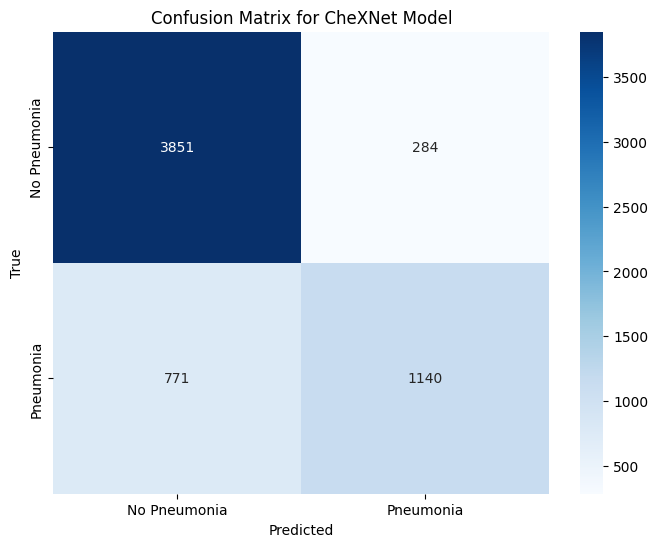

              precision    recall  f1-score   support

No Pneumonia       0.83      0.93      0.88      4135
   Pneumonia       0.80      0.60      0.68      1911

    accuracy                           0.83      6046
   macro avg       0.82      0.76      0.78      6046
weighted avg       0.82      0.83      0.82      6046



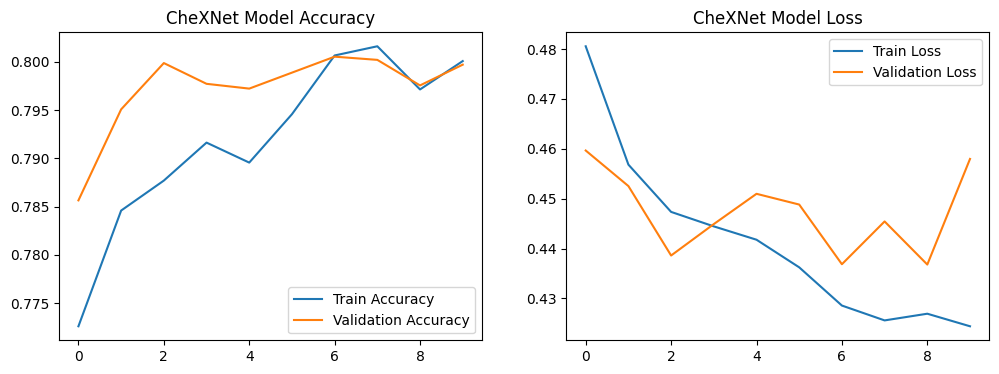

In [ ]:

# Load DenseNet-121

base_model.load_weights('/content/drive/MyDrive/Capstone project-Group 12/chexnet_weights.h5')

base_model = tf.keras.applications.DenseNet121(weights='weights', include_top=False, input_shape=(224, 224, 3))
# Freeze base model layers
base_model.trainable = False

# Add custom layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

# Create model
model = Model(inputs=base_model.input, outputs=outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Learning rate scheduler
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train model
history = model.fit(
    train_generator_custom,
    validation_data=(X_val, y_val),
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    callbacks=[lr_scheduler]
)

# Fine-tune
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False
model.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
train_generator_custom = custom_generator(train_generator, steps_per_epoch)  # Reset for fine-tuning
model.fit(
    train_generator_custom,
    validation_data=(X_val, y_val),
    epochs=5,
    steps_per_epoch=steps_per_epoch,
    callbacks=[lr_scheduler]
)

# Evaluate model and plot confusion matrix
y_pred = model.predict(X_val)
y_pred_binary = (y_pred > 0.5).astype(int).flatten()
cm = confusion_matrix(y_val, y_pred_binary)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Pneumonia', 'Pneumonia'], yticklabels=['No Pneumonia', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for CheXNet Model')
plt.savefig('/content/drive/MyDrive/Capstone project-Group 12/chexnet_confusion_matrix.png')
plt.show()

# Print classification report
print(classification_report(y_val, y_pred_binary, target_names=['No Pneumonia', 'Pneumonia']))

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('CheXNet Model Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('CheXNet Model Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/Capstone project-Group 12/chexnet_training_history.png')
plt.show()

# Save model
model.save('/content/drive/MyDrive/Capstone project-Group 12/chexnet_model.h5')


In [1]:
!pip install pydicom

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 22.8 MB/s eta 0:00:00


In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import cv2
import torch
import torch.nn as nn
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import zipfile
import pydicom
from pathlib import Path
from tqdm import tqdm
import time
from torch.amp import autocast, GradScaler
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import seaborn as sns


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.7'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
# Define function to unzip DICOM images from a zip file
# - Extracts images to a specified directory, handling nested structure
def unzip_images(zip_path, extract_path):
    inner_path = os.path.join(extract_path, 'stage_2_train_images')
    os.makedirs(inner_path, exist_ok=True)
    print(f"Extracting {zip_path}...")
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for file in zip_ref.namelist():
            if not file.startswith('__MACOSX') and file.endswith('.dcm'):
                # Extract to inner directory
                filename = os.path.basename(file)
                zip_ref.extract(file, extract_path)
                # Move to inner stage_2_train_images folder
                extracted_file = os.path.join(extract_path, file)
                target_file = os.path.join(inner_path, filename)
                if os.path.exists(extracted_file):
                    os.rename(extracted_file, target_file)
    extracted_files = [f for f in os.listdir(inner_path) if f.endswith('.dcm')]
    print(f"Total extracted DICOM files: {len(extracted_files)}")
    return inner_path

In [5]:
# Unzip images from single zip file
zip_path = '/content/drive/MyDrive/Capstone project-Group 12/stage_2_train_images.zip'
extract_path = '/content/stage_2_train_images'
image_dir = unzip_images(zip_path, extract_path)

Extracting /content/drive/MyDrive/Capstone project-Group 12/stage_2_train_images.zip...
Total extracted DICOM files: 26684


In [6]:
# Load Data
label_df = pd.read_csv('/content/drive/MyDrive/Capstone project-Group 12/stage_2_train_labels.csv')


In [7]:
# Define custom dataset class for pneumonia detection
# - Loads DICOM images and corresponding annotations
# - Applies data augmentation and validates bounding boxes
class PneumoniaDataset(Dataset):
    def __init__(self, dataframe, image_dir, transforms=None):
        self.df = dataframe
        self.image_dir = image_dir
        self.transforms = transforms
        self.image_ids = self.df['patientId'].unique()
        self.valid_image_ids = []
        for img_id in self.image_ids:
            img_path = os.path.join(self.image_dir, f"{img_id}.dcm")
            if os.path.exists(img_path):
                self.valid_image_ids.append(img_id)
            else:
                print(f"Warning: File not found for patientId {img_id}: {img_path}")
        print(f"Found {len(self.valid_image_ids)} valid images out of {len(self.image_ids)}")

    def __len__(self):
        return len(self.valid_image_ids)

    def __getitem__(self, idx):
        image_id = self.valid_image_ids[idx]
        img_path = os.path.join(self.image_dir, f"{image_id}.dcm")

        try:
            dicom = pydicom.dcmread(img_path)
            img = dicom.pixel_array

            if len(img.shape) == 3:
                img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            img = cv2.cvtColor(img.astype(np.uint8), cv2.COLOR_GRAY2RGB)

            boxes = []
            labels = []
            records = self.df[self.df['patientId'] == image_id]
            img_h, img_w = img.shape[:2]

            for _, row in records.iterrows():
                if row['Target'] == 1:
                    x, y, w, h = row['x'], row['y'], row['width'], row['height']
                    if (pd.notna(x) and pd.notna(y) and pd.notna(w) and pd.notna(h) and
                        w > 0 and h > 0 and
                        0 <= x < img_w and 0 <= y < img_h and
                        x + w <= img_w and y + h <= img_h):
                        boxes.append([x, y, x + w, y + h])
                        labels.append(1)
                    else:
                        print(f"Invalid box for {image_id}: x={x}, y={y}, w={w}, h={h}")

            if not boxes:
                print(f"Skipping image {image_id}: No valid positive annotations")
                return None, None

            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            labels = torch.ones(len(boxes), dtype=torch.int64)

            target = {
                'boxes': boxes,
                'labels': labels,
                'image_id': torch.tensor([idx])
            }

            print(f"Image {image_id}: boxes shape={boxes.shape}, labels shape={labels.shape}, boxes={boxes.tolist()}")

            if self.transforms:
                try:
                    augmented = self.transforms(image=img, bboxes=boxes, labels=labels.tolist())
                    img = augmented['image']
                    target['boxes'] = torch.as_tensor(augmented['bboxes'], dtype=torch.float32)
                    target['labels'] = torch.as_tensor(augmented['labels'], dtype=torch.int64)
                    if len(target['boxes']) == 0:
                        print(f"Skipping image {image_id}: No boxes after augmentation")
                        return None, None
                except Exception as e:
                    print(f"Augmentation error for {image_id}: {str(e)}")
                    return None, None

            return img, target
        except FileNotFoundError:
            print(f"Error: Could not load {img_path}")
            return None, None

In [8]:
# Define data augmentation pipelines
# - Training: Apply random transformations (e.g., flip, rotate) to increase robustness
# - Validation: Apply minimal preprocessing (resize, normalize)
train_transforms = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    A.Resize(512, 512),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.3, brightness_limit=0.2, contrast_limit=0.2),
    A.Rotate(limit=15, p=0.3),
    A.GaussNoise(p=0.2),
    A.RandomGamma(gamma_limit=(80, 120), p=0.3),
    A.Blur(blur_limit=3, p=0.2),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_area=0.1, min_visibility=0.1))

val_transforms = A.Compose([
    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0),
    A.Resize(512, 512),
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)),
    ToTensorV2()
], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['labels'], min_area=0.1, min_visibility=0.1))


Purpose: Applies random transformations to training images to increase model robustness by simulating variations in data.

    A.CLAHE(clip_limit=2.0, tile_grid_size=(8, 8), p=1.0): Applies Contrast Limited Adaptive Histogram Equalization to enhance image contrast, improving visibility of pneumonia regions. Always applied (p=1.0).
    A.Resize(512, 512): Resizes images to 512x512 pixels for consistent model input.
    A.HorizontalFlip(p=0.5): Flips images horizontally with 50% probability to augment data.
    A.RandomBrightnessContrast(p=0.3, brightness_limit=0.2, contrast_limit=0.2): Randomly adjusts brightness and contrast (within ±20%) with 30% probability to mimic lighting variations.
    A.Rotate(limit=15, p=0.3): Rotates images by up to ±15 degrees with 30% probability to handle orientation variations.
    A.GaussNoise(p=0.2): Adds Gaussian noise with 20% probability to improve robustness to image noise.
    A.RandomGamma(gamma_limit=(80, 120), p=0.3): Adjusts gamma (80-120% range) with 30% probability to vary image intensity.
    A.Blur(blur_limit=3, p=0.2): Applies blur (up to 3-pixel radius) with 20% probability to simulate out-of-focus images.
    A.Normalize(mean=(0.0, 0.0, 0.0), std=(1.0, 1.0, 1.0)): Normalizes RGB pixel values to zero mean and unit variance for model compatibility.
    ToTensorV2(): Converts images to PyTorch tensors, transposing to [C, H, W] format.
    bbox_params: Ensures bounding boxes (in Pascal VOC format: [x_min, y_min, x_max, y_max]) are adjusted with transformations, filtering out boxes with area < 0.1 or visibility < 10%.

    Bounding Box Parameters

    format='pascal_voc': Bounding boxes are in [x_min, y_min, x_max, y_max] format.
    label_fields=['labels']: Associates labels with bounding boxes during augmentation.
    min_area=0.1, min_visibility=0.1: Filters out boxes with area < 0.1 pixels or <10% visibility after augmentation to ensure valid annotations.

In [9]:
# Split Data
train_ids, val_ids = train_test_split(label_df['patientId'].unique(), test_size=0.2, random_state=42)
train_df = label_df[label_df['patientId'].isin(train_ids)]
val_df = label_df[label_df['patientId'].isin(val_ids)]

# Create dataset instances
# - Initialize datasets with respective transforms
train_dataset = PneumoniaDataset(train_df, image_dir, transforms=train_transforms)
val_dataset = PneumoniaDataset(val_df, image_dir, transforms=val_transforms)

# Filter out invalid (None) data entries
# - Remove samples where images or annotations are invalid
train_dataset = [data for data in train_dataset if data[0] is not None]
val_dataset = [data for data in val_dataset if data[0] is not None]


Streaming output truncated to the last 5000 lines.
Image 24bc6cbc-3ed9-455a-8fbf-f106ce3e1e59: boxes shape=torch.Size([1, 4]), labels shape=torch.Size([1]), boxes=[[223.0, 585.0, 359.0, 727.0]]
Skipping image 24ef2877-64ae-4c8a-acb5-6e1c302dc7d2: No valid positive annotations
Image 261341d3-1df2-4cf4-b9a8-b1e02a124900: boxes shape=torch.Size([3, 4]), labels shape=torch.Size([3]), boxes=[[594.0, 362.0, 717.0, 529.0], [553.0, 647.0, 749.0, 831.0], [229.0, 379.0, 373.0, 626.0]]
Image 26d622c4-c7ec-4952-9210-7b2a2144cb79: boxes shape=torch.Size([2, 4]), labels shape=torch.Size([2]), boxes=[[195.0, 339.0, 392.0, 716.0], [589.0, 391.0, 897.0, 648.0]]
Skipping image 27b2992d-54c7-4fcd-a060-b118bd8fe5ca: No valid positive annotations
Skipping image 27dc31f8-148e-42de-a6b4-60bfa79e20ae: No valid positive annotations
Skipping image 2875f1b1-25d0-455a-b098-728ae2ee84ce: No valid positive annotations
Skipping image 288f94e4-143c-4eaa-8353-7a0fecb52437: No valid positive annotations
Skipping image 

In [10]:
img, _ = train_dataset[0]
print(f"Image dtype: {img.dtype}, min: {img.min()}, max: {img.max()}")

Image dtype: torch.float32, min: 0.0, max: 0.6627451181411743


In [11]:
print(f"Valid training samples: {len(train_dataset)}")
print(f"Valid validation samples: {len(val_dataset)}")

Valid training samples: 4783
Valid validation samples: 1229


#Pipeline to load the data by using GPU(optimised for A100 GPU)

In [12]:
# DataLoader
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=8,
    pin_memory=True,
    collate_fn=lambda x: tuple(zip(*[item for item in x if item[0] is not None]))
)
val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=8,
    pin_memory=True,
    collate_fn=lambda x: tuple(zip(*[item for item in x if item[0] is not None]))
)

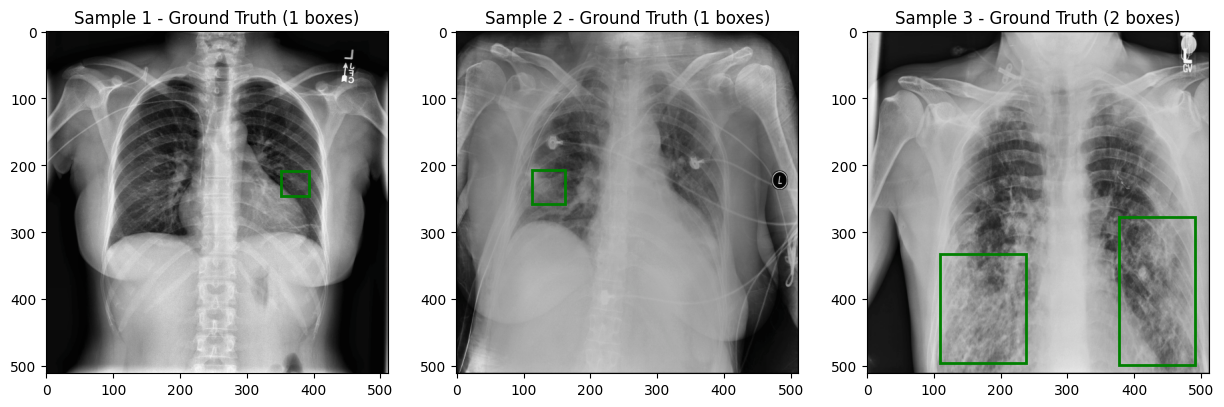

In [13]:
# Visualization of Sample Images with bounding box
def plot_sample_images(dataset, num_samples=3):
    plt.figure(figsize=(15, 5))
    samples_plotted = 0
    for i in range(len(dataset)):
        img, target = dataset[i]
        if img is None or target is None:
            continue
        img = img.permute(1, 2, 0).numpy() * 255
        img = np.clip(img, 0, 255).astype(np.uint8)

        plt.subplot(1, num_samples, samples_plotted+1)
        plt.imshow(img)
        boxes = target['boxes'].numpy()
        for box in boxes:
            x1, y1, x2, y2 = box
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='green', linewidth=2))
        plt.title(f"Sample {samples_plotted+1} - Ground Truth ({len(boxes)} boxes)")
        samples_plotted += 1
        if samples_plotted >= num_samples:
            break
    plt.show()

plot_sample_images(val_dataset)

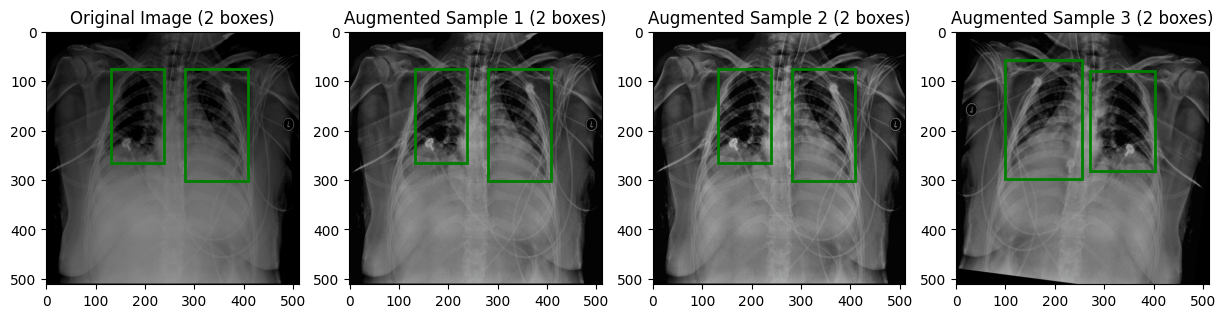

In [14]:
# Visualization of Augmentation Effects
def plot_augmentation_effects(dataset, idx=0):
    img, target = dataset[idx]
    if img is None or target is None:
        print(f"Skipping augmentation visualization for index {idx} due to missing data")
        return

    img = img.permute(1, 2, 0).numpy() * 255
    img = np.clip(img, 0, 255).astype(np.uint8)

    aug_images = []
    for _ in range(3):
        aug = train_transforms(image=img, bboxes=target['boxes'].numpy(), labels=target['labels'].tolist())
        aug_img = aug['image'].permute(1, 2, 0).numpy() * 255
        aug_img = np.clip(aug_img, 0, 255).astype(np.uint8)
        aug_images.append((aug_img, aug['bboxes']))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 4, 1)
    plt.imshow(img)
    for box in target['boxes'].numpy():
        x1, y1, x2, y2 = box
        plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='green', linewidth=2))
    plt.title(f"Original Image ({len(target['boxes'])} boxes)")

    for i, (aug_img, aug_boxes) in enumerate(aug_images):
        plt.subplot(1, 4, i+2)
        plt.imshow(aug_img)
        for box in aug_boxes:
            x1, y1, x2, y2 = box
            plt.gca().add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='green', linewidth=2))
        plt.title(f"Augmented Sample {i+1} ({len(aug_boxes)} boxes)")
    plt.show()

plot_augmentation_effects(train_dataset)


#Model Building and Training

aster R-CNN is used for pneumonia detection because:

    Accuracy: It combines a Region Proposal Network (RPN) with a CNN-based classifier, achieving high precision in detecting and localizing pneumonia regions in DICOM images.
    Efficiency: Faster than previous R-CNN models by integrating region proposals into the network, reducing computation time.
    Bounding Box Detection: Excels at predicting precise bounding boxes around pneumonia areas, critical for medical imaging tasks.
    Pre-trained Model: Uses a pre-trained ResNet50 backbone (fasterrcnn_resnet50_fpn), leveraging transfer learning for better performance on medical images with limited data.
    Robustness: Handles complex image variations (e.g., chest X-rays) through feature pyramid networks (FPN), improving detection across scales.

It’s well-suited for the task’s need for accurate localization and classification in medical imaging.

In [16]:
#Model Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = fasterrcnn_resnet50_fpn(weights="COCO_V1")
num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
# Multi-GPU support
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

model.to(device)

# Compile model
if torch.__version__ >= '2.0':
    model = torch.compile(model)
    print("Model compiled for optimization")

# Training
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
scaler = GradScaler('cuda')
num_epochs = 20
accumulation_steps = 4

for epoch in tqdm(range(num_epochs), desc="Training"):
    start_time = time.time()
    model.train()
    accumulated_loss = 0
    optimizer.zero_grad()

    for i, (images, targets) in enumerate(train_loader):
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        with autocast(device_type='cuda'):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            losses = losses / accumulation_steps

        scaler.scale(losses).backward()
        accumulated_loss += losses.item()

        if (i + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {accumulated_loss:.4f}, Time: {epoch_time:.2f}s")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 205MB/s]


Model compiled for optimization


Training:   0%|          | 0/20 [00:00<?, ?it/s]W0530 14:46:57.538000 873 torch/_dynamo/variables/tensor.py:869] [0/0] Graph break from `Tensor.item()`, consider setting:
W0530 14:46:57.538000 873 torch/_dynamo/variables/tensor.py:869] [0/0]     torch._dynamo.config.capture_scalar_outputs = True
W0530 14:46:57.538000 873 torch/_dynamo/variables/tensor.py:869] [0/0] or:
W0530 14:46:57.538000 873 torch/_dynamo/variables/tensor.py:869] [0/0]     env TORCHDYNAMO_CAPTURE_SCALAR_OUTPUTS=1
W0530 14:46:57.538000 873 torch/_dynamo/variables/tensor.py:869] [0/0] to include these operations in the captured graph.
W0530 14:46:57.538000 873 torch/_dynamo/variables/tensor.py:869] [0/0] 
W0530 14:46:57.538000 873 torch/_dynamo/variables/tensor.py:869] [0/0] Graph break: from user code at:
W0530 14:46:57.538000 873 torch/_dynamo/variables/tensor.py:869] [0/0]   File "/usr/local/lib/python3.11/dist-packages/torchvision/models/detection/generalized_rcnn.py", line 83, in forward
W0530 14:46:57.538000 873

Epoch 1/20, Loss: 24.8667, Time: 435.00s


Training:  10%|█         | 2/20 [09:06<1:13:21, 244.55s/it]

Epoch 2/20, Loss: 22.3947, Time: 111.23s


Training:  15%|█▌        | 3/20 [10:57<52:04, 183.79s/it]  

Epoch 3/20, Loss: 21.9699, Time: 111.48s


Training:  20%|██        | 4/20 [12:48<41:22, 155.16s/it]

Epoch 4/20, Loss: 21.1134, Time: 111.27s


Training:  25%|██▌       | 5/20 [14:40<34:50, 139.36s/it]

Epoch 5/20, Loss: 20.7234, Time: 111.34s


Training:  30%|███       | 6/20 [16:33<30:27, 130.55s/it]

Epoch 6/20, Loss: 20.2738, Time: 113.46s


Training:  35%|███▌      | 7/20 [18:25<26:56, 124.34s/it]

Epoch 7/20, Loss: 20.0828, Time: 111.55s


Training:  40%|████      | 8/20 [20:16<24:03, 120.26s/it]

Epoch 8/20, Loss: 19.6263, Time: 111.52s


Training:  45%|████▌     | 9/20 [22:08<21:31, 117.45s/it]

Epoch 9/20, Loss: 19.0880, Time: 111.29s


Training:  50%|█████     | 10/20 [23:59<19:15, 115.58s/it]

Epoch 10/20, Loss: 18.7832, Time: 111.37s


Training:  55%|█████▌    | 11/20 [25:50<17:08, 114.30s/it]

Epoch 11/20, Loss: 18.2257, Time: 111.40s


Training:  60%|██████    | 12/20 [27:42<15:07, 113.38s/it]

Epoch 12/20, Loss: 17.6222, Time: 111.29s


Training:  65%|██████▌   | 13/20 [29:33<13:09, 112.85s/it]

Epoch 13/20, Loss: 17.0298, Time: 111.60s


Training:  70%|███████   | 14/20 [31:25<11:14, 112.45s/it]

Epoch 14/20, Loss: 16.3300, Time: 111.53s


Training:  75%|███████▌  | 15/20 [33:16<09:20, 112.15s/it]

Epoch 15/20, Loss: 15.4586, Time: 111.48s


Training:  80%|████████  | 16/20 [35:08<07:28, 112.04s/it]

Epoch 16/20, Loss: 14.6198, Time: 111.78s


Training:  85%|████████▌ | 17/20 [37:00<05:35, 111.90s/it]

Epoch 17/20, Loss: 13.8652, Time: 111.58s


Training:  90%|█████████ | 18/20 [38:52<03:43, 111.88s/it]

Epoch 18/20, Loss: 13.0947, Time: 111.83s


Training:  95%|█████████▌| 19/20 [40:43<01:51, 111.81s/it]

Epoch 19/20, Loss: 12.3943, Time: 111.62s


Training: 100%|██████████| 20/20 [42:35<00:00, 127.77s/it]

Epoch 20/20, Loss: 11.5738, Time: 111.67s


In [17]:
# Save model to Google Drive
torch.save(model.state_dict(), '/content/drive/MyDrive/Capstone project-Group 12/faster_rcnn_pneumonia_clahe.pth')

#Evaluation metrics

Computing Intersection over union, mean absolute precision using COCO detectors

In [18]:
# Compute IoU
def compute_iou(box1, box2):
    x1_1, y1_1, x2_1, y2_1 = box1
    x1_2, y1_2, x2_2, y2_2 = box2

    xi1 = max(x1_1, x1_2)
    yi1 = max(y1_1, y1_2)
    xi2 = min(x2_1, x2_2)
    yi2 = min(y2_1, y2_2)

    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)

    box1_area = (x2_1 - x1_1) * (y2_1 - y1_1)
    box2_area = (x2_2 - x1_2) * (y2_2 - y1_2)

    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area > 0 else 0

In [19]:
# Compute Metrics
def compute_metrics(model, data_loader, device, iou_threshold=0.5):
    model.eval()
    gt_data = []
    pred_data = []
    img_id = 0
    ann_id = 1

    with torch.no_grad():
        for images, targets in data_loader:
            images = [img.to(device) for img in images]
            outputs = model(images)

            for i, (output, target) in enumerate(zip(outputs, targets)):
                img_id += 1
                gt_boxes = target['boxes'].cpu().numpy()
                gt_labels = target['labels'].cpu().numpy()

                for box, label in zip(gt_boxes, gt_labels):
                    x1, y1, x2, y2 = box
                    gt_data.append({
                        'id': ann_id,
                        'image_id': img_id,
                        'category_id': int(label),
                        'bbox': [float(x1), float(y1), float(x2-x1), float(y2-y1)],
                        'area': float((x2-x1) * (y2-y1)),
                        'iscrowd': 0
                    })
                    ann_id += 1

                pred_boxes = output['boxes'].cpu().numpy()
                pred_scores = output['scores'].cpu().numpy()
                pred_labels = output['labels'].cpu().numpy()

                for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
                    if score > 0.5:
                        x1, y1, x2, y2 = box
                        pred_data.append({
                            'image_id': img_id,
                            'category_id': int(label),
                            'bbox': [float(x1), float(y1), float(x2-x1), float(y2-y1)],
                            'score': float(score)
                        })

    import json
    with open('gt_coco.json', 'w') as f:
        json.dump({
            'images': [{'id': i+1, 'width': 512, 'height': 512} for i in range(img_id)],
            'annotations': gt_data,
            'categories': [{'id': 1, 'name': 'pneumonia'}]
        }, f)

    with open('pred_coco.json', 'w') as f:
        json.dump(pred_data, f)

    coco_gt = COCO('gt_coco.json')
    coco_dt = coco_gt.loadRes('pred_coco.json')
    coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()

    mAP = coco_eval.stats[0]
    mAP_50 = coco_eval.stats[1]
    mAP_75 = coco_eval.stats[2]

    true_positives = 0
    false_positives = 0
    total_gt = sum(len(t['boxes']) for t in targets)

    for i, (output, target) in enumerate(zip(outputs, targets)):
        pred_boxes = output['boxes'].cpu().numpy()
        pred_scores = output['scores'].cpu().numpy()
        gt_boxes = target['boxes'].cpu().numpy()

        matched = set()
        for pred_idx, (pred_box, score) in enumerate(zip(pred_boxes, pred_scores)):
            if score <= 0.5:
                continue
            for gt_idx, gt_box in enumerate(gt_boxes):
                if gt_idx in matched:
                    continue
                if compute_iou(pred_box, gt_box) >= iou_threshold:
                    true_positives += 1
                    matched.add(gt_idx)
                    break
            else:
                false_positives += 1

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / total_gt if total_gt > 0 else 0

    return {
        'mAP': mAP,
        'mAP_50': mAP_50,
        'mAP_75': mAP_75,
        'precision': precision,
        'recall': recall
    }


In [20]:
# Visualize Predictions with Saving to Drive
def visualize_predictions(model, data_loader, device, num_samples=3):
    model.eval()
    samples_plotted = 0
    activation_threshold = 1e-4

    output_dir = '/content/drive/MyDrive/Capstone project-Group 12/'
    os.makedirs(output_dir, exist_ok=True)
    print(f"Saving visualizations to {output_dir}")

    feature_maps = []
    def hook(module, input, output):
        print(f"Hook triggered, output shape: {output.shape}")
        feature_maps.append(output)

    hook_handle = model.backbone.body.layer4[-1].conv3.register_forward_hook(hook)
    print("Hook registered on layer4[-1].conv3")

    try:
        with torch.no_grad():
            for images, targets in data_loader:
                images = [image.to(device) for image in images]
                print(f"Batch size: {len(images)}")
                outputs = model(images)

                if not feature_maps:
                    print("Error: No feature maps captured. Check hook or model architecture.")
                    break

                for i, (image, target, output) in enumerate(zip(images, targets, outputs)):
                    if samples_plotted >= num_samples:
                        break

                    img = image.permute(1, 2, 0).cpu().numpy() * 255
                    img = np.clip(img, 0, 255).astype(np.uint8)

                    gt_boxes = target['boxes'].cpu().numpy()
                    pred_boxes = output['boxes'].cpu().numpy()
                    pred_scores = output['scores'].cpu().numpy()
                    pred_labels = output['labels'].cpu().numpy()

                    if i < len(feature_maps):
                        fmap = feature_maps[i].cpu().numpy()
                        print(f"Image {i+1}: Raw fmap shape: {fmap.shape}")
                        fmap = np.mean(fmap, axis=(0, 1))
                        print(f"Image {i+1}: Aggregated fmap shape: {fmap.shape}")
                        fmap = cv2.resize(fmap, (img.shape[1], img.shape[0]))
                        print(f"Image {i+1}: Resized fmap shape: {fmap.shape}, min: {fmap.min()}, max: {fmap.max()}")

                        activation_range = fmap.max() - fmap.min()
                        print(f"Image {i+1}: Activation range: {activation_range}")
                        if activation_range < activation_threshold:
                            print(f"Image {i+1}: Skipping due to low activation (range={activation_range})")
                            continue

                        fmap = (fmap - fmap.min()) / (fmap.max() - fmap.min() + 1e-8)
                        print(f"Image {i+1}: Normalized fmap shape: {fmap.shape}, min: {fmap.min()}, max: {fmap.max()}")
                    else:
                        print(f"Image {i+1}: Error: No feature map for index {i}. Skipping.")
                        continue

                    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

                    ax1.imshow(img)
                    for box in gt_boxes:
                        x1, y1, x2, y2 = box
                        ax1.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))
                    ax1.set_title(f"Ground Truth ({len(gt_boxes)} boxes)")
                    ax1.axis('off')

                    ax2.imshow(img)
                    ax2.imshow(fmap, cmap='jet', alpha=0.5, interpolation='bicubic')
                    for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
                        if score > 0.5:
                            x1, y1, x2, y2 = box
                            ax2.add_patch(plt.Rectangle(
                                (x1, y1), x2-x1, y2-y1,
                                facecolor=(0, 1, 0, 0.3), edgecolor='green', linewidth=2
                            ))
                            ax2.text(x1, y1-10, f'{score:.2f}', color='white', fontsize=10, bbox=dict(facecolor='green', alpha=0.5))
                    ax2.set_title(f"Predicted with Heatmap ({sum(pred_scores > 0.5)} boxes)")
                    ax2.axis('off')

                    ax3.imshow(fmap, cmap='jet')
                    ax3.set_title(f"Feature Map Activation (Image {i+1})")
                    ax3.axis('off')

                    predicted_path = os.path.join(output_dir, f"predicted_image_{i+1}.png")
                    fig.savefig(predicted_path, bbox_inches='tight', dpi=300)
                    print(f"Saved predicted image: {predicted_path}")

                    fig_temp, ax_temp = plt.subplots(figsize=(6, 6))
                    ax_temp.imshow(fmap, cmap='jet')
                    ax_temp.set_title(f"Feature Map Activation (Image {i+1})")
                    ax_temp.axis('off')
                    featuremap_path = os.path.join(output_dir, f"feature_map_{i+1}.png")
                    fig_temp.savefig(featuremap_path, bbox_inches='tight', dpi=300)
                    plt.close(fig_temp)
                    print(f"Saved feature map: {featuremap_path}")

                    plt.show()
                    plt.close(fig)
                    samples_plotted += 1

                feature_maps.clear()
                if samples_plotted >= num_samples:
                    break
    finally:
        hook_handle.remove()

In [21]:
# Evaluation with Metrics and Visualization
def evaluate(model, data_loader, device, num_samples=3):
    model.eval()
    samples_plotted = 0

    metrics = compute_metrics(model, data_loader, device)
    print(f"Evaluation Metrics:")
    print(f"mAP (0.5:0.95): {metrics['mAP']:.4f}")
    print(f"mAP@0.5: {metrics['mAP_50']:.4f}")
    print(f"mAP@0.75: {metrics['mAP_75']:.4f}")
    print(f"Precision: {metrics['precision']:.4f}")
    print(f"Recall: {metrics['recall']:.4f}")

    with torch.no_grad():
        for images, targets in data_loader:
            images = [image.to(device) for image in images]
            outputs = model(images)

            for i, (image, target, output) in enumerate(zip(images, targets, outputs)):
                if samples_plotted >= num_samples:
                    break

                img = image.permute(1, 2, 0).cpu().numpy() * 255
                img = np.clip(img, 0, 255).astype(np.uint8)

                gt_boxes = target['boxes'].cpu().numpy()
                pred_boxes = output['boxes'].cpu().numpy()
                pred_scores = output['scores'].cpu().numpy()
                pred_labels = output['labels'].cpu().numpy()

                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

                ax1.imshow(img)
                for box in gt_boxes:
                    x1, y1, x2, y2 = box
                    ax1.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1, fill=False, edgecolor='red', linewidth=2))
                ax1.set_title(f"Ground Truth ({len(gt_boxes)} boxes)")
                ax1.axis('off')

                ax2.imshow(img)
                for box, score, label in zip(pred_boxes, pred_scores, pred_labels):
                    if score > 0.5:
                        x1, y1, x2, y2 = box
                        ax2.add_patch(plt.Rectangle(
                            (x1, y1), x2-x1, y2-y1,
                            facecolor=(0, 1, 0, 0.3), edgecolor='green', linewidth=2
                        ))
                        ax2.text(x1, y1-10, f'{score:.2f}', color='white', fontsize=10, bbox=dict(facecolor='green', alpha=0.5))
                ax2.set_title(f"Predicted ({sum(pred_scores > 0.5)} boxes)")
                ax2.axis('off')

                plt.show()
                samples_plotted += 1

            if samples_plotted >= num_samples:
                break

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.02s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.52s).
Accumulating evaluation results...
DONE (t=0.08s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.117
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.375
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.039
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.149
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.141
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.276
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDet

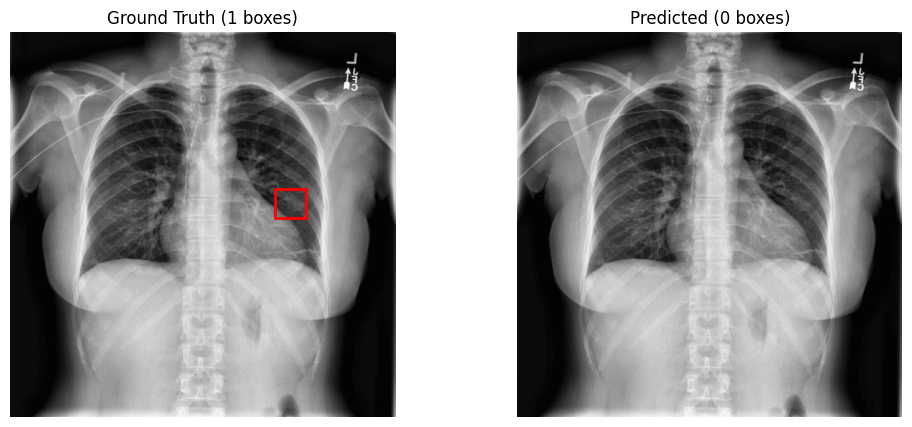

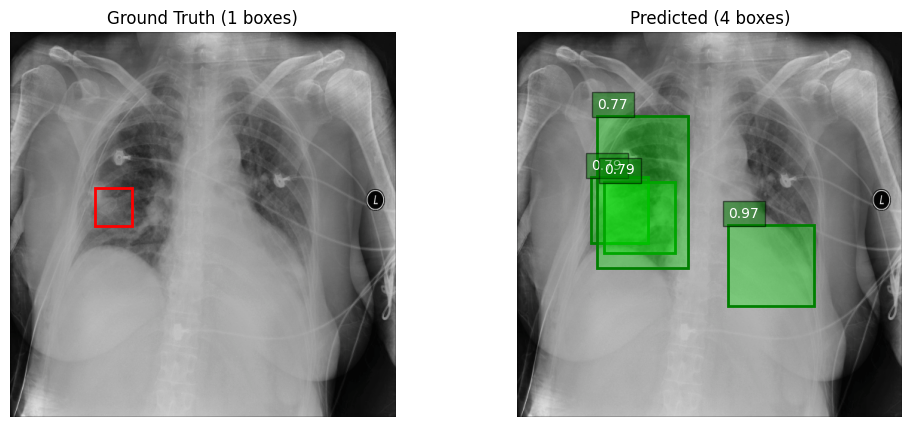

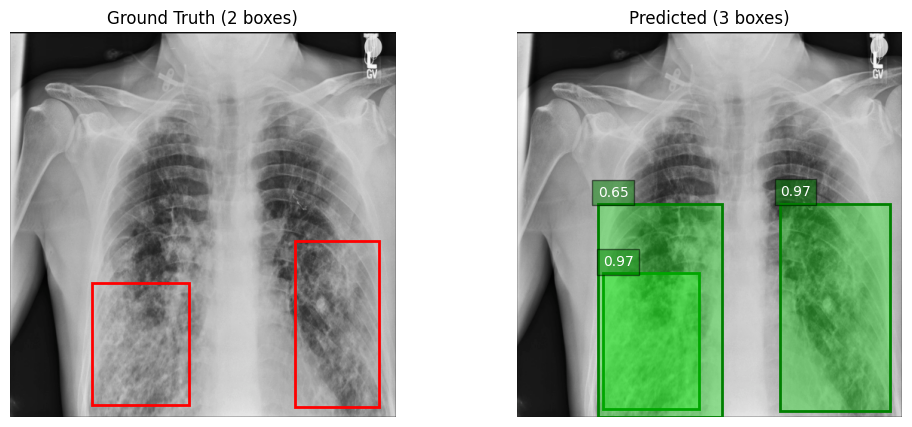

Saving visualizations to /content/drive/MyDrive/Capstone project-Group 12/
Hook registered on layer4[-1].conv3
Batch size: 16
Hook triggered, output shape: torch.Size([16, 2048, 25, 25])
Image 1: Raw fmap shape: (16, 2048, 25, 25)
Image 1: Aggregated fmap shape: (25, 25)
Image 1: Resized fmap shape: (512, 512), min: -0.03369743749499321, max: -0.011705050244927406
Image 1: Activation range: 0.021992387250065804
Image 1: Normalized fmap shape: (512, 512), min: 0.0, max: 0.9999995827674866
Saved predicted image: /content/drive/MyDrive/Capstone project-Group 12/predicted_image_1.png
Saved feature map: /content/drive/MyDrive/Capstone project-Group 12/feature_map_1.png


Image 2: Error: No feature map for index 1. Skipping.
Image 3: Error: No feature map for index 2. Skipping.
Image 4: Error: No feature map for index 3. Skipping.
Image 5: Error: No feature map for index 4. Skipping.
Image 6: Error: No feature map for index 5. Skipping.
Image 7: Error: No feature map for index 6. Skipping.
Image 8: Error: No feature map for index 7. Skipping.
Image 9: Error: No feature map for index 8. Skipping.
Image 10: Error: No feature map for index 9. Skipping.
Image 11: Error: No feature map for index 10. Skipping.
Image 12: Error: No feature map for index 11. Skipping.
Image 13: Error: No feature map for index 12. Skipping.
Image 14: Error: No feature map for index 13. Skipping.
Image 15: Error: No feature map for index 14. Skipping.
Image 16: Error: No feature map for index 15. Skipping.
Batch size: 16
Hook triggered, output shape: torch.Size([16, 2048, 25, 25])
Image 1: Raw fmap shape: (16, 2048, 25, 25)
Image 1: Aggregated fmap shape: (25, 25)
Image 1: Resized

Image 2: Error: No feature map for index 1. Skipping.
Image 3: Error: No feature map for index 2. Skipping.
Image 4: Error: No feature map for index 3. Skipping.
Image 5: Error: No feature map for index 4. Skipping.
Image 6: Error: No feature map for index 5. Skipping.
Image 7: Error: No feature map for index 6. Skipping.
Image 8: Error: No feature map for index 7. Skipping.
Image 9: Error: No feature map for index 8. Skipping.
Image 10: Error: No feature map for index 9. Skipping.
Image 11: Error: No feature map for index 10. Skipping.
Image 12: Error: No feature map for index 11. Skipping.
Image 13: Error: No feature map for index 12. Skipping.
Image 14: Error: No feature map for index 13. Skipping.
Image 15: Error: No feature map for index 14. Skipping.
Image 16: Error: No feature map for index 15. Skipping.
Batch size: 16
Hook triggered, output shape: torch.Size([16, 2048, 25, 25])
Image 1: Raw fmap shape: (16, 2048, 25, 25)
Image 1: Aggregated fmap shape: (25, 25)
Image 1: Resized

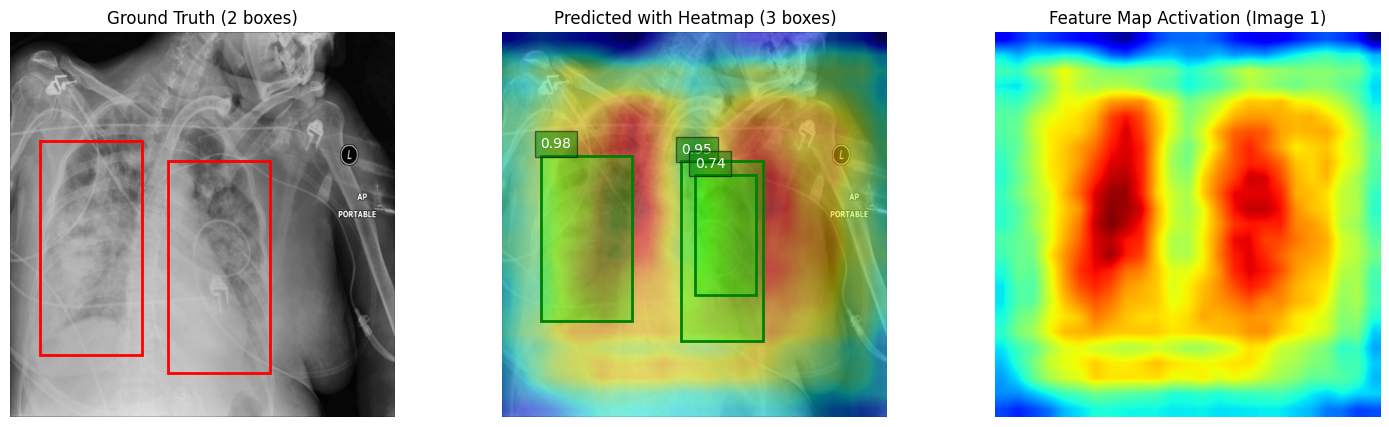

In [22]:
# Run Evaluation and Visualization
evaluate(model, val_loader, device)
visualize_predictions(model, val_loader, device)